/home/cheikh/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Class weights: {0: 0.6777816321221056, 1: 1.906219512195122}
Epoch 1/100


2025-03-29 11:11:13.002035: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 60019200 exceeds 10% of free system memory.


391/391 ━━━━━━━━━━━━━━━━━━━━ 50s 118ms/step - accuracy: 0.8901 - f1_metric: 8.3065 - loss: 0.2920 - val_accuracy: 0.9498 - val_f1_metric: 7.6898 - val_loss: 0.1205
Epoch 2/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 92s 144ms/step - accuracy: 0.9341 - f1_metric: 9.1589 - loss: 0.1485 - val_accuracy: 0.9463 - val_f1_metric: 7.7536 - val_loss: 0.1273
Epoch 3/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 55s 141ms/step - accuracy: 0.9359 - f1_metric: 9.0926 - loss: 0.1458 - val_accuracy: 0.9463 - val_f1_metric: 7.7911 - val_loss: 0.1292
Epoch 4/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 74s 119ms/step - accuracy: 0.9480 - f1_metric: 9.0669 - loss: 0.1186 - val_accuracy: 0.9536 - val_f1_metric: 7.1025 - val_loss: 0.1042
Epoch 5/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 78s 108ms/step - accuracy: 0.9459 - f1_metric: 8.9236 - loss: 0.1205 - val_accuracy: 0.9565 - val_f1_metric: 7.6872 - val_loss: 0.0994
Epoch 6/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 43s 109ms/step - accuracy: 0.9543 - f1_metric: 9.0700 - loss: 0.1053 - val_accuracy: 0.9524

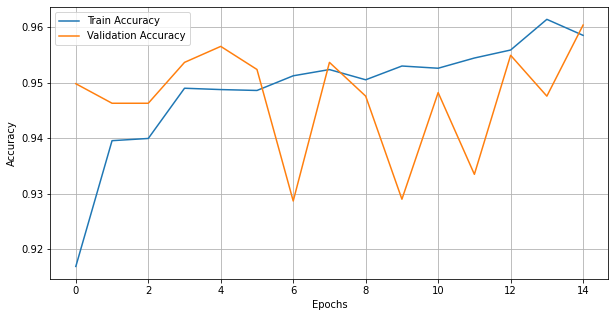

256/256 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step


Test Accuracy: 0.6573
Test F1-Score: 0.3126


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K

# --- Load datasets ---
sequence_length = 50
U = 40  # threshold for classification
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
train_file_path = 'train_FD001.txt'
test_file_path = 'test_FD001.txt'

df_train = pd.read_csv(train_file_path, delim_whitespace=True, header=None)
df_test = pd.read_csv(test_file_path, delim_whitespace=True, header=None)

# --- Column names ---
column_names = ['unit', 'cycle', 'operational_setting_1', 'operational_setting_2',
                'operational_setting_3', 'sensor_1', 'sensor_2', 'sensor_3', 'sensor_4',
                'sensor_5', 'sensor_6', 'sensor_7', 'sensor_8', 'sensor_9', 'sensor_10',
                'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15',
                'sensor_16', 'sensor_17', 'sensor_18', 'sensor_19', 'sensor_20', 'sensor_21']
df_train.columns = column_names
df_test.columns = column_names

# --- Compute RUL and label ---
rul_df_train = df_train.groupby('unit')['cycle'].max().reset_index()
rul_df_train.columns = ['unit', 'max_cycle']
df_train = df_train.merge(rul_df_train, on='unit')
df_train['RUL'] = df_train['max_cycle'] - df_train['cycle']
df_train.drop(columns=['max_cycle'], inplace=True)
df_train['label'] = (df_train['RUL'] <= U).astype(int)

rul_df_test = df_test.groupby('unit')['cycle'].max().reset_index()
rul_df_test.columns = ['unit', 'max_cycle']
df_test = df_test.merge(rul_df_test, on='unit')
df_test['RUL'] = df_test['max_cycle'] - df_test['cycle']
df_test.drop(columns=['max_cycle'], inplace=True)
df_test['label'] = (df_test['RUL'] <= U).astype(int)

# --- Normalize sensor data ---
scaler = MinMaxScaler()
sensor_columns = column_names[2:]
df_train[sensor_columns] = scaler.fit_transform(df_train[sensor_columns])
df_test[sensor_columns] = scaler.transform(df_test[sensor_columns])

# --- Create sequences ---
def create_sequences(data, seq_length=25, classification=True):
    sequences, labels = [], []
    for unit in data['unit'].unique():
        unit_data = data[data['unit'] == unit]
        for i in range(len(unit_data) - seq_length):
            seq = unit_data.iloc[i:i+seq_length][sensor_columns].values
            label = unit_data.iloc[i+seq_length]['label'] if classification else unit_data.iloc[i+seq_length]['RUL']
            sequences.append(seq)
            labels.append(label)
    return np.array(sequences), np.array(labels)

X_train, y_train = create_sequences(df_train, seq_length=sequence_length, classification=True)
X_test, y_test = create_sequences(df_test, seq_length=sequence_length, classification=True)

# --- Reshape ---
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

# --- Define custom F1 metric ---
def f1_metric(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true * y_pred, 'float'))
    precision = tp / (K.sum(K.cast(y_pred, 'float')) + K.epsilon())
    recall = tp / (K.sum(K.cast(y_true, 'float')) + K.epsilon())
    return 2*(precision*recall)/(precision+recall+K.epsilon())

# --- Model definition ---
model = Sequential([
    LSTM(150, return_sequences=True, input_shape=(sequence_length, len(sensor_columns))),
    Dropout(0.2),
    LSTM(100, return_sequences=False),
    Dense(50, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_metric])

# --- Compute class weights ---
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))
print("Class weights:", class_weight_dict)

# --- Train the model ---
epochs = 100
batch_size = 32

history = model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.2,
    callbacks=[early_stopping],
    class_weight=class_weight_dict
)

# --- Plot training accuracy ---
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# --- Evaluate on test set ---
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob >= 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test F1-Score: {f1:.4f}")

# --- Save model ---
model.save('lstm_classification_model.h5')


In [12]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# --------------------------
# 1. Génération des données synthétiques
# --------------------------
np.random.seed(42)
n_samples = 1000
n_components = 10

data = []
for _ in range(n_samples):
    for comp_id in range(n_components):
        rij = np.round(np.random.uniform(0, 1), 3)
        age = np.random.randint(1, 200)
        last_maint = np.random.choice([0, 1, 2, 3, 4])
        cost = [0, 30, 75, 150, 250][last_maint]
        time = [0.0, 0.8, 2.0, 3.5, 5.0][last_maint]

        # Niveau optimal simulé selon fiabilité
        if rij < 0.2:
            optimal_level = 4
        elif rij < 0.4:
            optimal_level = 3
        elif rij < 0.6:
            optimal_level = 2
        elif rij < 0.8:
            optimal_level = 1
        else:
            optimal_level = 0

        data.append([comp_id, rij, age, last_maint, cost, time, optimal_level])

df = pd.DataFrame(data, columns=[
    'component_id', 'reliability', 'age', 'last_maintenance', 'cost', 'time', 'optimal_level'
])

# --------------------------
# 2. Entraînement du modèle
# --------------------------
X = df[['component_id', 'reliability', 'age', 'last_maintenance', 'cost', 'time']]
y = df['optimal_level']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print("Évaluation du modèle :\n")
print(classification_report(y_test, y_pred))

# --------------------------
# 3. Utilisation sur un scénario réel
# --------------------------
new_components = pd.DataFrame({
    'component_id': list(range(10)),
    'reliability': [0.85, 0.62, 0.4, 0.25, 0.9, 0.75, 0.58, 0.33, 0.18, 0.95],
    'age': [100, 120, 80, 60, 90, 110, 70, 50, 40, 130],
    'last_maintenance': [0, 1, 2, 3, 0, 1, 2, 3, 4, 0]
})

new_components['cost'] = new_components['last_maintenance'].map({0: 0, 1: 30, 2: 75, 3: 150, 4: 250})
new_components['time'] = new_components['last_maintenance'].map({0: 0.0, 1: 0.8, 2: 2.0, 3: 3.5, 4: 5.0})

X_new = new_components[['component_id', 'reliability', 'age', 'last_maintenance', 'cost', 'time']]
new_components['predicted_optimal_level'] = clf.predict(X_new)

print("\nPrédictions pour un nouveau scénario :\n")
print(new_components[['component_id', 'reliability', 'age', 'last_maintenance', 'predicted_optimal_level']])


Évaluation du modèle :

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       384
           1       1.00      1.00      1.00       402
           2       1.00      1.00      1.00       405
           3       1.00      1.00      1.00       410
           4       1.00      1.00      1.00       399

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000


Prédictions pour un nouveau scénario :

   component_id  reliability  age  last_maintenance  predicted_optimal_level
0             0         0.85  100                 0                        0
1             1         0.62  120                 1                        1
2             2         0.40   80                 2                        2
3             3         0.25   60                 3                        3
4             4         0.90   90                 0          